In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
import multiprocessing
from collections import Counter
import itertools
import json
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]

from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)


In [2]:
df = pd.read_msgpack('../../allan_data/user_data_properties.msgpack')

In [3]:
ua = loaders.Useralias() 
with open('../../allan_data/phonenumbers.json') as fid:
    phonebook = json.load(fid)

In [4]:
df.head() 

,bt_timespan,call_count,call_timespan,sms_count,sms_timespan,user
useralias,,,,,,
u0182,466 days 04:10:04,20.0,411 days 16:28:54,149.0,411 days 08:01:30,28b76d7b7879d364321f164df5169f
u1015,574 days 17:23:57,68.0,570 days 19:13:33,276.0,569 days 03:43:58,f41c375b5c87d3593b963b49a3f9a3
u0778,508 days 22:29:51,4.0,353 days 13:59:21,24.0,729 days 18:24:48,b600d2468831e0b3480a69af903dfc
u0933,514 days 02:33:14,145.0,498 days 00:14:03,200.0,498 days 05:41:58,dbbf1adb3264464838b938429d674b
u0256,305 days 07:02:31,20.0,283 days 06:59:02,121.0,292 days 01:19:01,3b6887b57d97d1ff1e1a674abfa5e3


In [5]:
user = df.iloc[0, 5]
user

'28b76d7b7879d364321f164df5169f'

## Bluetooth

Do this:

1. Keep those users which are present in 2 or more timeslots
2. Discard those users which were recorded as being in the 2 previous timeslots

In [6]:
def aggfnc(s):
    if len(s):
        return set(s)
    return None

In [7]:
def user_bt_interactions(user):
    dct = loaders.loadUser2(user, dataFilter=('bluetooth', ))
    dbt = pd.DataFrame(dct['bluetooth'])
    dbt = dbt[dbt.scanned_user.str.len() == 30]  # filter out non-participants
    dbt['timestamp'] = pd.to_datetime(dbt.timestamp, unit='s')
    dbt = dbt[(dbt.timestamp.dt.hour > 17) | (dbt.timestamp.dt.hour < 7)]
    dbt = dbt.set_index('timestamp') 
    agg_5m = dbt[['scanned_user']].groupby(pd.Grouper(freq='5Min')).agg(aggfnc) 
    dct = dict()
    discard_next_iteration = set() 
    for p0, p1 in zip(range(0, agg_5m.shape[0]-1), range(1, agg_5m.shape[0])):
        p0d = agg_5m.iloc[p0, 0]
        p1d = agg_5m.iloc[p1, 0]
        if p0d and p1d:
            in_both = agg_5m.iloc[p0, 0].intersection(agg_5m.iloc[p1, 0])
            if in_both:
                recorded = {ua[el] for el in in_both}
                dct[agg_5m.index[p0]] = recorded - discard_next_iteration
                discard_next_iteration = recorded

    adj = pd.Series(dct) 
    return adj

In [ ]:
gbt = nx.DiGraph() 
dct_bt = dict()
for user in df.iloc[0:4, 5]:
    print(repr(user))
    adj = user_bt_interactions(user)
    adj = adj[adj.map(len) > 0]  # remove empty timebins
    adj_summarized = pd.Series(Counter(itertools.chain(*adj)))
    dct_bt[ua[user]] = (adj, adj_summarized)
    gbt.add_edges_from((ua[user], contact, {'weight': weight}) for contact, weight in adj_summarized.iteritems())

'28b76d7b7879d364321f164df5169f'


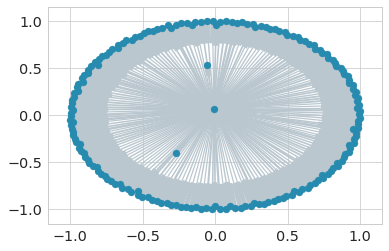

In [10]:
plotting.drawWeightedGraph(gbt, nodeLabels=False)

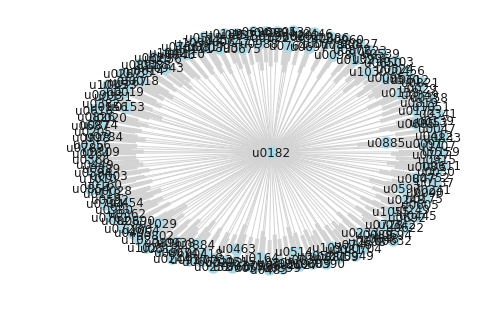

In [11]:
plotting.nxQuickDraw(gbt)

## SMS

In [12]:
dsm = pd.DataFrame(loaders.loadUser2(user, dataFilter=('sms', ))['sms']) 
dsm = dsm[dsm.address.str.len() > 0]
dsm = dsm[dsm.address.isin(phonebook.keys())]
dsm['address'] = dsm.address.replace(phonebook).replace(ua.userdct)
dsm['timestamp'] = pd.to_datetime(dsm.timestamp, unit='s')

In [13]:
gsm = nx.DiGraph() 
gsm.add_edges_from((ua[user], contact, {'weight': weight}) for contact, weight in dsm.address.value_counts().iteritems())

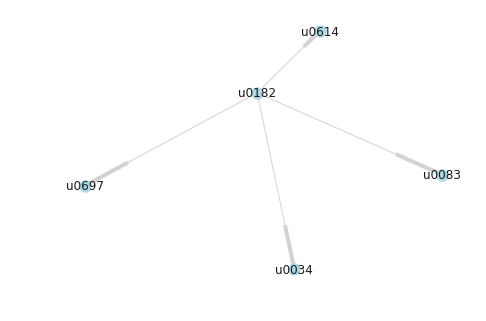

In [14]:
plotting.nxQuickDraw(gsm)

## Call

In [15]:
dca = pd.DataFrame(loaders.loadUser2(user, dataFilter=('call', ))['call']) 
dca = dca.rename(columns={'number': 'address'})
dca = dca[dca.address.str.len() > 0]
dca = dca[dca.address.isin(phonebook.keys())]
dca['address'] = dca.address.replace(phonebook).replace(ua.userdct)
dca['timestamp'] = pd.to_datetime(dca.timestamp, unit='s')

In [16]:
gca = nx.DiGraph() 
gca.add_edges_from((ua[user], contact, {'weight': weight}) for contact, weight in dca.address.value_counts().iteritems())

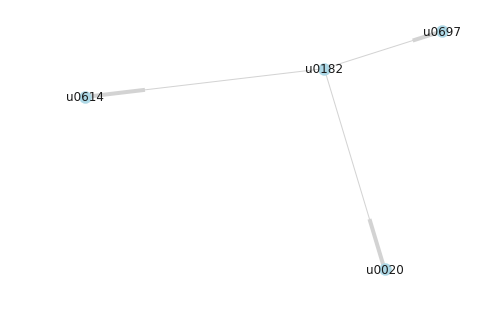

In [17]:
plotting.nxQuickDraw(gca)